# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [73]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [74]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
sent_df = df.drop(columns="fng_classification")
sent_df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
hist_df = df.sort_index()
hist_df = hist_df.to_frame()
hist_df.tail()

,Close
Date,
2019-07-25,9882.429688
2019-07-26,9847.450195
2019-07-27,9478.320313
2019-07-28,9531.769531
2019-07-29,9529.889648


In [5]:
# Join the data into a single DataFrame
both_df = sent_df.join(hist_df, how="inner")
both_df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
both_df.dtypes 

 fng_value      int64
Close         float64
dtype: object

In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y 
def window_data(both_df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(both_df) - window - 1):
        feature = both_df.iloc[i:(i + window), feature_col_number]
        target = both_df.iloc[(i + window), target_col_number]
        X.append(feature)
        y.append(target)
# Is the reshape converting the vectors into a vertical shape?
# Removed the reshape for the X array and the X shape is (532, 10)
# W/ reshape, it's (5320, 1)
    return np.array(X), np.array(y).reshape(-1, 1)

In [75]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3 # Changed from 10 to 1 / 2nd Change: From 1 to 5 and this was the only change when running through the RNN again (Failed, keep at 1)

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
# window_data(array, window, ..., ...)
# Need to change to float value(s) potentially because this needs 2 be between 0 to 1.
X, y = window_data(both_df, window_size, feature_column, target_column)

In [76]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
from sklearn.model_selection import train_test_split
# Look into getting input variables w/ inconsistent numbers of samples: [5320, 532]. 5320 is probably X & 532 is probably y.
# Had this issue w/ my LSTM model from the project, so if this gets figured out I should change some of what I wrote there.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [77]:
y.shape # y still won't change the window_size to 10

(539, 1)

In [78]:
X_train_split = int(0.7 * len(X))
X_train = X[: X_train_split]
X_test_split = int(0.3 * len(X))
X_test = X[X_test_split :]

# Make y splits
y_train_split = int(0.7 * len(y))
y_train = y[: y_train_split]
y_test_split = int(0.3 * len(y))
y_test = y[y_test_split:]

In [79]:
from sklearn.preprocessing import MinMaxScaler # To adjust the shape difference(s) between the data
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler() # Default is already feature_range=0,1

# Training sets
x_scaler.fit(X_train)
y_scaler.fit(y_train)

# Scaling for X sets
#scaler = scaler.fit(X)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

# Scaling for y sets. y is already vertical so that's why I don't need to reshape that data
#scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

# Checking outputs to see if they're within the desired 0-1 range
#print(X_train) # Worked fine
#print(X_test) # Worked fine
#print(y_train) # Worked fine
#print(y_test) # Worked fine

In [80]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# To attempt dealing with the incompatible error when attempting to recover the original prices vs scaled version
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
#y_test = y_test.reshape((y_test.shape[0]), y_test.shape[1], 1)
#print(f"X_train sample values:\n{X_train[: 5]}\n") # Some values are missing 
#print(f"X_test sample values:\n{X_test[:5]}") # Works fine

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [82]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
# YOUR CODE HERE!
model = Sequential()
# num_unitz
# 1st attempt: Changed from 5 to 25, no error but the predictions are still flat.
# 2nd attempt: Changed from 25 to 40, predictions are still flat.
# 3rd attempt: Changed from 40 to 30, was decent.
num_unitz = 30 # This parameter is okay to change. 
drop_prct = .23 
# drop_prct
# Attempt 1: Changed from .2 to .15 / Attempt 2: Changed from .15 back to .2 / Attempt 3: Changed from .2 to .22 (Score doubled)
# Attempt 4: Changed from .22 to .25 alone as the only change (Score dropped from .1236 area to .0755) / Attempt 5: Changed window_size back to 1 and drop_prct back to .23
# CHANGING UNITZ TO 33 & DROP_PRCT TO .175 FAILLLLLEEEEDDDD
# Layer 1
# How can I go about resetting the input_shape in case the parameters are to small without getting an error after training the model?? ***
model.add(LSTM(units=num_unitz, return_sequences=True, input_shape = ((X_train.shape[1], 1)))) # DON'T TOUCH ANYTHING
# 3D array is as follows = (batch_size of 3, time steps of 1, & number of units in 1 input sequence)
model.add(Dropout(drop_prct))
# Layer 2
model.add(LSTM(units=num_unitz, return_sequences=True))
model.add(Dropout(drop_prct)) # Syntax error where I put Dense in instead of Dropout. From run 57 -> 58 for the cell
# Layer 3
model.add(LSTM(units=num_unitz))
model.add(Dropout(drop_prct))
# Output Layer
model.add(Dense(1))

In [83]:
# Compile the model
# YOUR CODE HERE!
model.compile(optimizer="adam", loss="mean_squared_error") # Attempt 1: Changed from 'sgd' to 'adam'

In [84]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 30)             3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 30)             7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [85]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1) # Trying to increase epochs when this cell was @ 62 FAILED
# DON'T CHANGE EPOCHS

Epoch 1/10
377/377 [==============================] - 6s 3ms/step - loss: 0.0453
Epoch 2/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0330
Epoch 3/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0354
Epoch 4/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0334
Epoch 5/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0352
Epoch 6/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0346
Epoch 7/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0330
Epoch 8/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0348
Epoch 9/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 10/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0398


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [86]:
model.evaluate(X_test, y_test, verbose=0) # Number moved up by almost double when I minimized the batch_size from 50 to 1, changed the Dense mistake, and switch from optimizer 'sgd' to 'adam'
# Next attempt after the leap by double the score: Went from .11... to .064

0.10315069556236267

In [87]:
# Make some predictions
# YOUR CODE HERE!
X_predictionz = model.predict(X_test)
# Incompatible: y_predictionz = model.predict(y_test)

In [88]:
# Recover the original prices instead of the scaled version
predicted_prices = y_scaler.inverse_transform(X_predictionz)
real_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [89]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head() # Need to figure out what went wrong with my predictions (Score improved from .06 area to the .1236 area after only changing my drop_prct)***

,Real,Predicted
Date,,
2018-07-17,7383.390137,4156.635742
2018-07-18,7477.500000,4334.198730
2018-07-19,7333.930176,4486.166992
2018-07-20,7405.399902,4632.140137
2018-07-21,7398.640137,4708.076172


<AxesSubplot:title={'center':'Real prices vs. Predictions'}, xlabel='Date'>

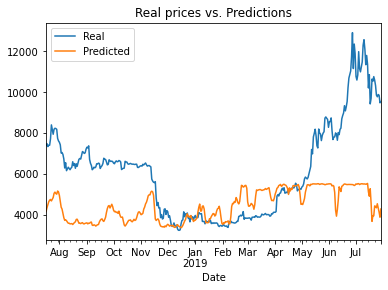

In [90]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
stocks.plot(title="Real prices vs. Predictions")